# Load data

In [49]:
import numpy as np
import pandas as pd
import json
import os
import glob
import warnings
from pathlib import Path
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.animation as anime
warnings.simplefilter('ignore')
%matplotlib inline

In [50]:
DATA_FOLDER = "../data"
OUTPUT_FOLDER = "./output"
USER_ID = "N01T1"
keypoint_csv = DATA_FOLDER + "/keypoints/{}_keypoint.csv".format(USER_ID)
keypoint_files = glob.glob(os.path.join(DATA_FOLDER, "keypoints", "*_keypoint.csv"))

# Processing Data

In [51]:
FS = 30 # sampling rate
TOTAL_CLASSESS = 9
SMOOTH_LEN = 3 # seconds

def load_data(keypoint_csv, ann_csv):
  kp_df = pd.read_csv(keypoint_csv)
  kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('^Unnamed')]

  ann_df = pd.read_csv(ann_csv)
  ann_df = ann_df.loc[:, ~ann_df.columns.str.contains('^Unnamed')]

  return kp_df, ann_df

def remove_redundant_kp(kp_df):
  kp_df = kp_df.loc[:, ~kp_df.columns.str.contains(
      'conf|left_eye|right_eye|left_ear|right_ear|left_knee|right_knee|left_ankle|right_ankle', regex=True)]
  return kp_df

def smooth_kp(kp_col):
  zero_idx = np.flatnonzero(kp_col == 0)
  split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
  for each_split_idx in split_idx:
    if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > SMOOTH_LEN*FS:
      continue
    xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
    fp = kp_col[xp]
    interp_kp = np.interp(each_split_idx, xp, fp)
    kp_col[each_split_idx] = interp_kp
  return kp_col

def normalize_data(data):
    # Normalize data to the range [0, 1]
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)

    return normalized_data.fillna(0)

def change_point_detection(df,col, model):
    models = {
        'AutoRegressive': rpt.Dynp(model="ar", params={"order": 7}).fit(df[col].values),
        'L2': rpt.Dynp(model="l2").fit(df[col].values),
        'Normal': rpt.Dynp(model="normal", params={"add_small_diag": False}).fit(df[col].values),
    }
    # Using AutoRegressive model
    algo = models[model]
    result = algo.predict(n_bkps=9)
    print('Change Point Location: ',result)
    return result

def ann_kp_combine_df(ann_df: pd.DataFrame, kp_df: pd.DataFrame):
    # Assigning Labels to rows within the timeframe
    for index, row in ann_df.iterrows():
        start_time = row['start_time']
        stop_time = row['stop_time']
        label = row['annotation']
        kp_df.loc[start_time * FS:stop_time * FS, 'label'] = label
    return kp_df

def label_sample_split(subject_id: str, kp_ann_df: pd.DataFrame):
  array_values = kp_ann_df.to_numpy()
  num_columns = len(kp_ann_df.columns)
  result_list = []  # Each element contains a list of (x,y) tuple coordinates of a body part

  # Convert DataFrame to List holding data from each rows
  for row in array_values:
      temp_list = []
      # Loop through each x,y coord columns
      for i in range(0, num_columns, 2):
          if i + 1 < num_columns:
              temp_list.append([row[i], row[i + 1]])
      result_list.append(temp_list)

  labels = set(array_values[:, -1])
  for label in labels:
      # Find all occurences of that label and get the row (aka list of coords tuple) belong to it
      output = [result_list[idx] for idx, i in enumerate(array_values) if i[-1] == label]
      data = {
          "filename": f"{subject_id}_{label}",
          "skeletons": output,
          "label": label
      }
      output_file = os.path.join(OUTPUT_FOLDER, "Dataset", f"{subject_id}_{label}.json")
      with open(output_file, 'w') as json_file:
          # The JSON File Contain a list of Frames comprise of skeleton points (x,y) coordinates for a specified label from a Nurse
          json.dump(data, json_file)

In [ ]:
# Generate JSON Format
for keypoint_file in keypoint_files:
  subject_id = os.path.basename(keypoint_file).split("_")[0]
  ann_csv = os.path.join(DATA_FOLDER, "ann", f"{subject_id}_ann.csv")
  if not Path(ann_csv).exists():
    print(f"File: {subject_id}_ann.csv Doesn't Exist")
    continue
  kp_df, ann_df = load_data(keypoint_file, ann_csv)
  kp_df = remove_redundant_kp(kp_df)
  #kp_df = normalize_data(kp_df)

  for i in range(len(kp_df.columns)):
    kp_df.iloc[:, i] = smooth_kp(np.array(kp_df.iloc[:, i]))

  kp_df['label'] = None

  kp_ann_df = ann_kp_combine_df(ann_df,kp_df)
  label_sample_split(subject_id, kp_ann_df)



In [54]:
# Generate kp_ann_label_split
keypoint_files = glob.glob(os.path.join(DATA_FOLDER, "keypoints","train", "*_keypoint.csv"))
for keypoint_file in keypoint_files:
  subject_id = os.path.basename(keypoint_file).split("_")[0]
  ann_csv = os.path.join(DATA_FOLDER, "ann", f"{subject_id}_ann.csv")
  if not Path(ann_csv).exists():
    print(f"File: {subject_id}_ann.csv Doesn't Exist")
    continue
  kp_df, ann_df = load_data(keypoint_file, ann_csv)
  kp_df = remove_redundant_kp(kp_df)
  #kp_df = normalize_data(kp_df)

  for i in range(len(kp_df.columns)):
    kp_df.iloc[:, i] = smooth_kp(np.array(kp_df.iloc[:, i]))

  kp_df['label'] = None

  kp_ann_df = ann_kp_combine_df(ann_df,kp_df)
  for label, kp_ann  in kp_ann_df.groupby('label'):
    output_file = f"{subject_id}.csv"
    output_dir = Path(f"{OUTPUT_FOLDER}/label_split/label_{label}")
    output_dir.mkdir(parents=True, exist_ok=True)
    kp_ann.to_csv(output_dir / output_file,index=False)
  break

In [43]:
kp_ann_df.columns

Index(['nose_x', 'nose_y', 'left_shoulder_x', 'left_shoulder_y',
       'right_shoulder_x', 'right_shoulder_y', 'left_elbow_x', 'left_elbow_y',
       'right_elbow_x', 'right_elbow_y', 'left_wrist_x', 'left_wrist_y',
       'right_wrist_x', 'right_wrist_y', 'left_hip_x', 'left_hip_y',
       'right_hip_x', 'right_hip_y', 'label'],
      dtype='object')

In [44]:
change_points = change_point_detection(kp_ann_df,[
          'nose_x','nose_y',
          'left_shoulder_x','left_shoulder_y',
          'right_shoulder_x','right_shoulder_y',
          'left_elbow_x','left_elbow_y',
          'right_elbow_x','right_elbow_y',
          'left_wrist_x','left_wrist_y',
          'right_wrist_x','right_wrist_y',
          'left_hip_x','left_hip_y',
          'right_hip_x','right_hip_y',
    ], "AutoRegressive")

Change Point Location:  [385, 1885, 3325, 4440, 5215, 6720, 7520, 8660, 9345, 9510]


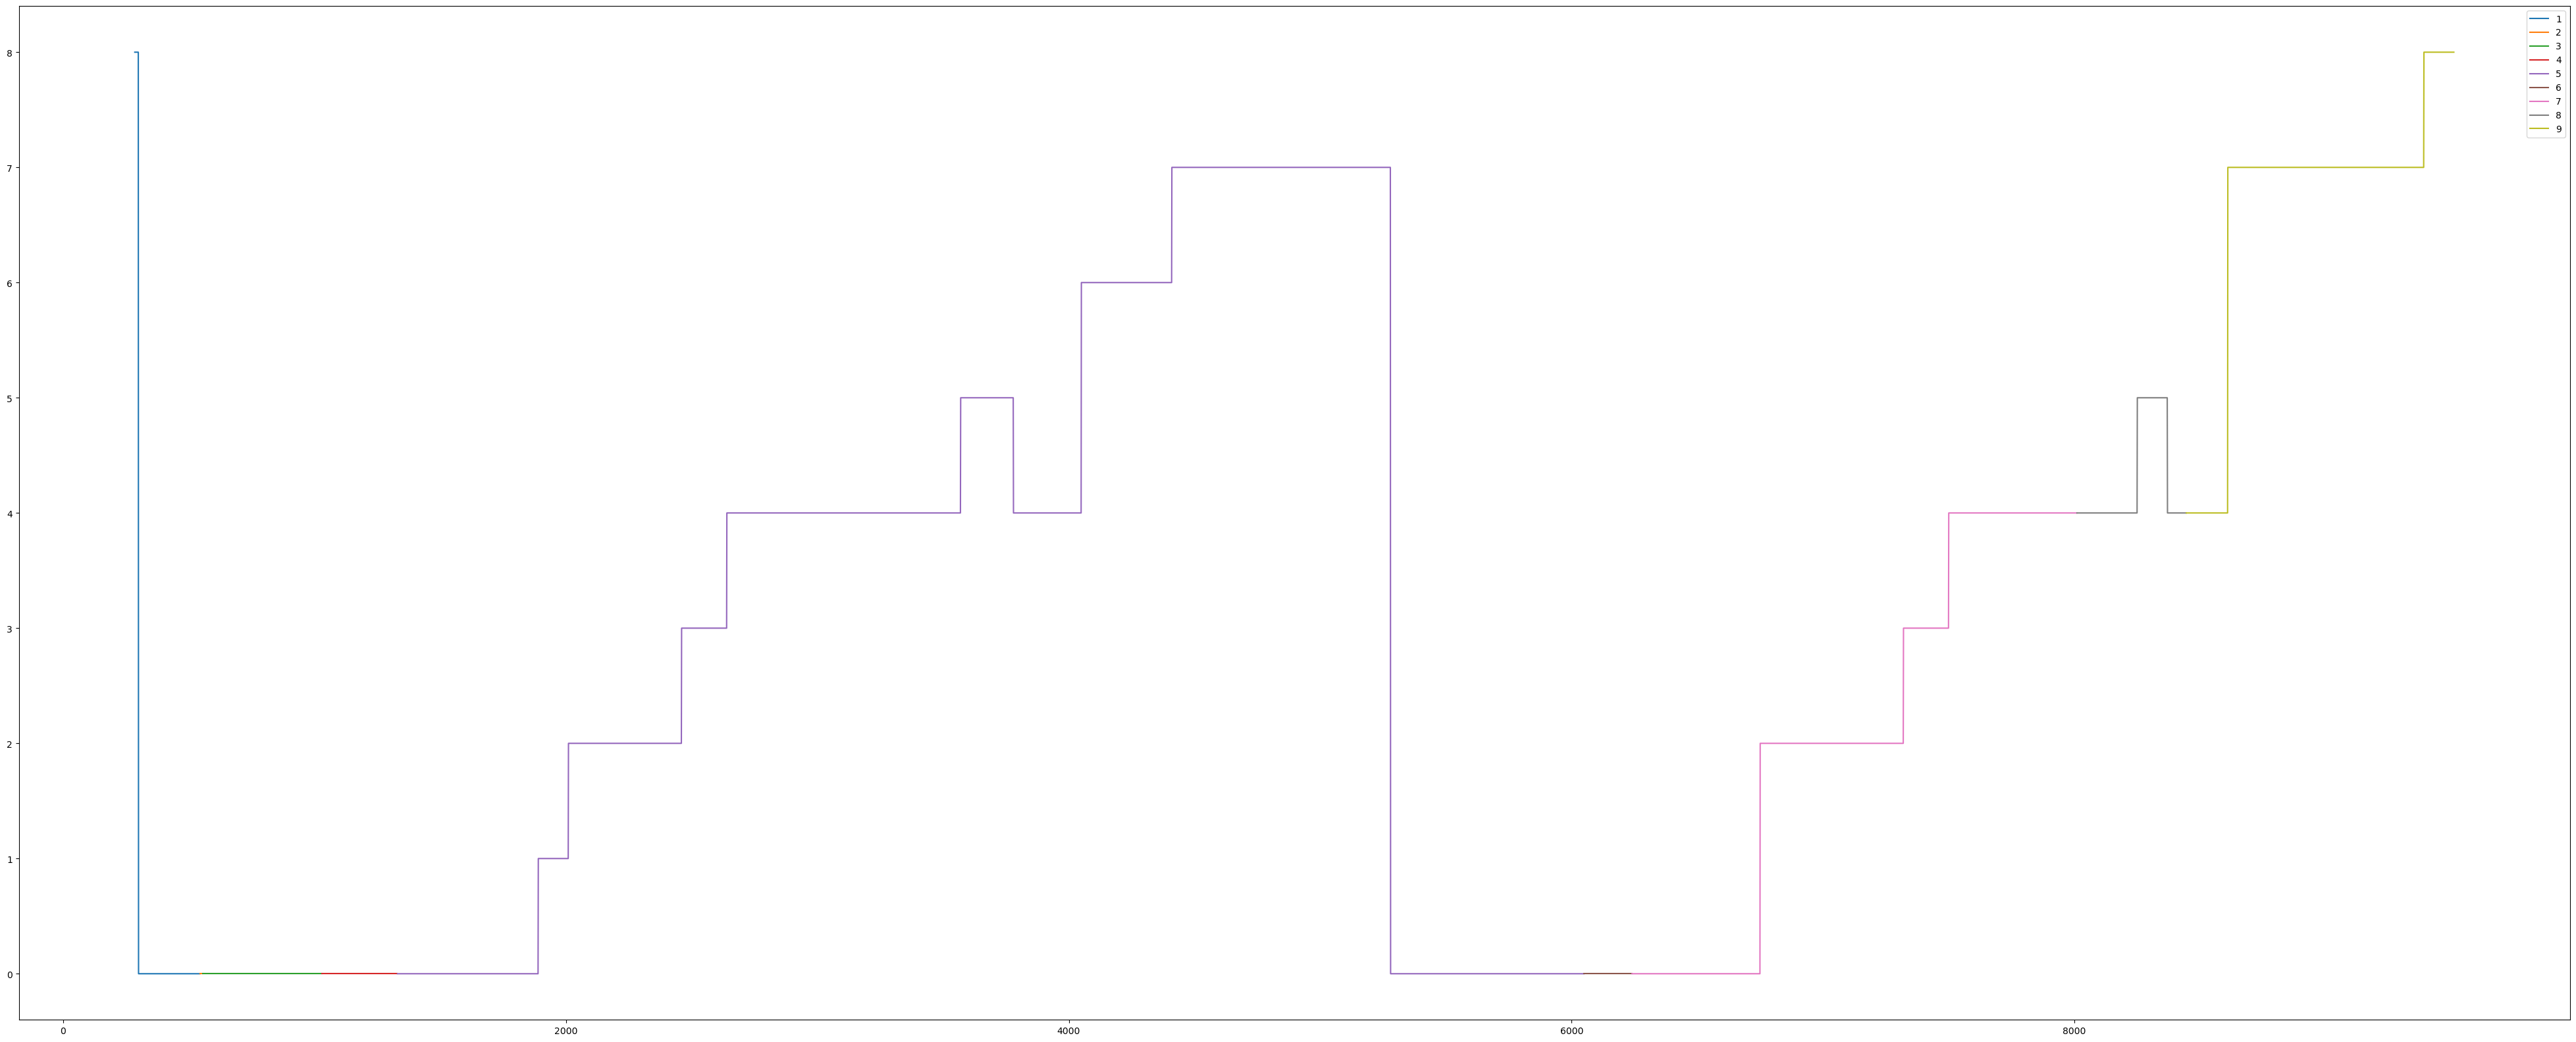

In [45]:
change_points = [285, 545, 555, 1030, 1330, 6050, 6240, 8010, 8445, 9510]
plt.figure(figsize=(50,20))
for ip in range(1, len(change_points)):
    plt.plot(kp_ann_df['label'][change_points[ip-1]: change_points[ip]],label=ip)
plt.legend()

In [48]:
kp_ann_df['label'].to_csv('./labels.csv')